## **Setup**

In [12]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U
!pip install -q trl
# !pip install -q numpy

In [13]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft
from itertools import chain
from collections import Counter
import collections
import math
import numpy as np
from scipy.special import softmax
import pandas as pd

## **Setup**

In [14]:
class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
    return [f"{100 * trainable_params / all_param}", f"{trainable_params}"]

numParamsInfo = {}
numParamsTrained = {}

## **Data Loading and Tokenization**

In [15]:
data = []
prompts = []
responses = []
only_sherlock_data = []
with open("context_data_all.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            promptLine = "Respond to the following prompt in an arrogant and intelligent way, as if you were the fictional character Sherlock Holmes. \"" +  f"{lines[i].strip()}" + "\""
            responseLine = f"{lines[i+1].strip()}"
            prompts.append(promptLine)
            responses.append("Sherlock: " + responseLine)
            only_sherlock_data.append(responseLine)
            data.append("Prompt: \n" + promptLine + "\n### Response: \n" + responseLine)

In [16]:
def prompt_formatter(data):
    output_texts = []
    text = f"{data['Prompt']} \n{data['Response']}"
    output_texts.append(text)
    return output_texts

In [17]:
len(data)

1443

In [18]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [19]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)
train_ds = Dataset.from_dict({"text" : train_data})
val_ds = Dataset.from_dict({"text" : val_data})
print(train_ds)

Dataset({
    features: ['text'],
    num_rows: 1154
})


## **Training**

In [20]:
#Hyperparam setup
hyperparams = [0.001, 0.01, 0.05, 0.1, 0.25]
validation_losses = {x: [] for x in hyperparams} # {hyperparam_value: validation_losses}
training_losses = {x: [] for x in hyperparams} # {hyperparam_value: training_losses}

In [21]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

for hyperparam in hyperparams:
  config = LoraConfig(
      r=2,
      lora_alpha=4,
      lora_dropout=hyperparam,# THIS IS THE HYPERPARAMETER
      bias="none",
      task_type="CAUSAL_LM"
  )
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  # Freezing the model
  for param in model.parameters():
    param.requires_grad = False
    if param.ndim == 1:
      param.data = param.data.to(torch.float32)

  model.gradient_checkpointing_enable()
  model.enable_input_require_grads()
  model.lm_head = CastOutputToFloat(model.lm_head)
  model = get_peft_model(model, config)
  trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=512,
    packing=False,
    formatting_func=prompt_formatter,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=500,
        learning_rate=2e-3,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator = DataCollatorForCompletionOnlyLM("Prompt: ", tokenizer=tokenizer)
  )
  model.config.use_cache = False
  trainer.train()

  res = print_trainable_parameters(model)
  numParamsInfo[hyperparam] = res[0]
  numParamsTrained[hyperparam] = res[1]

  # populating data dictionaries
  for i, x in enumerate(trainer.state.log_history[:-1]):
    if (i+1) % 21 == 0:
      validation_losses[hyperparam].append(x["eval_loss"])
    else:
      training_losses[hyperparam].append(x["loss"])
  training_losses[hyperparam] = [sum(training_losses[hyperparam][i:i+20]) / 20 for i in range(0, len(training_losses[hyperparam]), 20)]


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.186800,3.906850
40,3.450200,3.282321
60,2.526600,2.396718
80,2.360400,2.309974
100,2.464800,2.264509
120,2.070500,2.230489
140,2.066400,2.201543
160,2.257100,2.174771
180,2.191500,2.149393
200,2.055800,2.130114


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.188400,3.909096
40,3.475600,3.305911
60,2.525800,2.400833
80,2.365000,2.308534
100,2.453700,2.263592
120,2.071000,2.232100
140,2.060100,2.199228
160,2.252700,2.173742
180,2.184000,2.149036
200,2.059700,2.128552


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.189800,3.909427
40,3.477000,3.309129
60,2.527600,2.401186
80,2.365900,2.308702
100,2.453100,2.263947
120,2.073000,2.232454
140,2.060300,2.199819
160,2.250200,2.173812
180,2.186300,2.149246
200,2.060600,2.129488


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.190000,3.910502
40,3.477500,3.307494
60,2.526900,2.401965
80,2.365600,2.309846
100,2.452900,2.264337
120,2.069400,2.233527
140,2.063700,2.200588
160,2.251500,2.175084
180,2.191200,2.150359
200,2.060600,2.129900


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.190200,3.912145
40,3.482800,3.310813
60,2.532600,2.405203
80,2.367800,2.310098
100,2.453200,2.264632
120,2.077800,2.233173
140,2.070600,2.201705
160,2.252100,2.175675
180,2.193000,2.152093
200,2.065400,2.131325


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


trainable params: 73728 || all params: 124513536 || trainable%: 0.05921283931732531


## **Graphs and Visualizations**

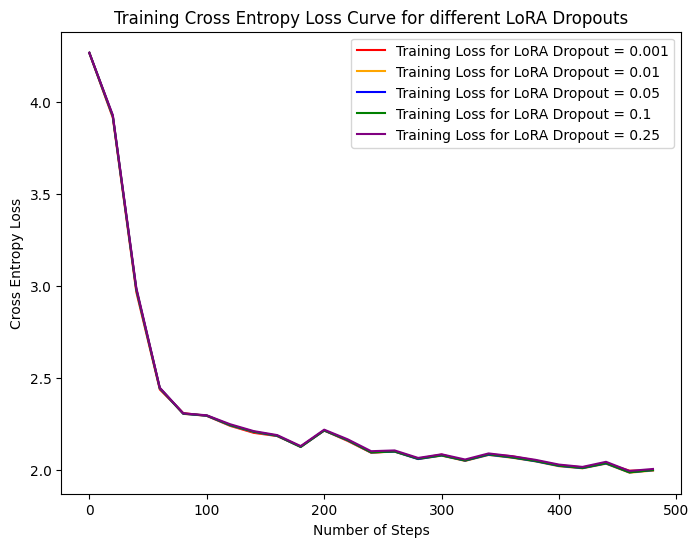

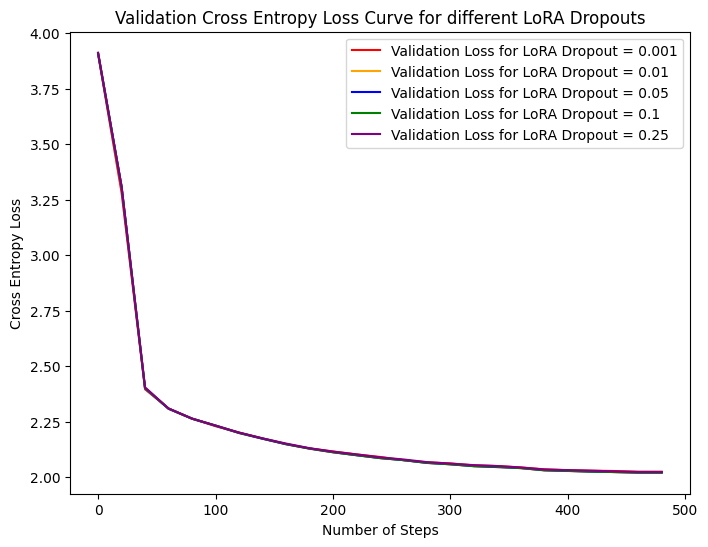

In [22]:
colors = ["red", "orange", "blue", "green", "purple"]

#Training Loss
plt.figure(figsize=(8, 6))
for i in range(len(hyperparams)):
    plt.plot(training_losses[hyperparams[i]], label=f"Training Loss for LoRA Dropout = {hyperparams[i]}", color=colors[i])

plt.xticks([0, 5, 10, 15, 20, 25], [0, 100, 200, 300, 400, 500])
plt.xlabel("Number of Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve for different LoRA Dropouts")
plt.legend()
plt.show()


#Validation Loss
plt.figure(figsize=(8, 6))
for i in range(len(hyperparams)):
    plt.plot(validation_losses[hyperparams[i]], label=f"Validation Loss for LoRA Dropout = {hyperparams[i]}", color=colors[i])

plt.xticks([0, 5, 10, 15, 20, 25], [0, 100, 200, 300, 400, 500])
plt.xlabel("Number of Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve for different LoRA Dropouts")
plt.legend()
plt.show()